In [1]:
import os
from google.colab import drive
drive.mount("/content/drive", force_remount=False)
 

Mounted at /content/drive


In [2]:
os.chdir("/content/drive/My Drive/driveArea")

In [3]:
import tensorflow as tf
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10932122934002867672
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 12056947170527323601
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 5098704607151996790
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14640891840
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14997597754898638050
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


In [4]:
import tensorflow as tf
import cv2
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [5]:
with open("./images_3000_160.p",'rb') as f:
  images = pickle.load(f)

In [6]:
with open("./labels_3000_160.p",'rb') as f:
  labels = pickle.load(f)

In [ ]:
print(len(labels))
print(len(images))

3000
3000


<_io.BufferedReader name='./labels_3000_160.p'>


list

In [ ]:
# Convert all black pixels to green and store in new_labels
import numpy as np
new_labels = []
for label in labels:
  for x in range (label.shape[0]):
     for y in range(label.shape[1]):
       if(np.all(label[x][y] == [0,0,0])):
         label[x][y] = [0,1,0]
  new_labels.append(label)

   

3000


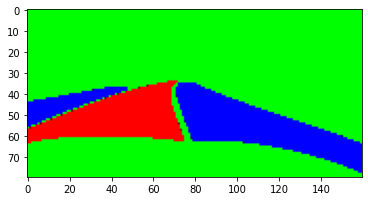

In [ ]:
plt.imshow(new_labels[2])
print(len(new_labels))

In [ ]:
#Data Augmentation

def flip_image(img):
  return cv2.flip(img,1)

flipped_images = []
flipped_labels = []

# Flip images 

for i in images:
  flipped_images.append(flip_image(i))
print(len(flipped_images))
 

for i in labels:
  flipped_labels.append(flip_image(i))




3000


In [ ]:
print(len(flipped_images))
print(len(flipped_labels))

3000
3000


In [ ]:
print(len(images))
print(len(labels))

3000
3000


In [ ]:
# Append transformations to images and labels
print(type(flipped_images))
images.extend(flipped_images)
labels.extend(flipped_labels)
print(len(images))
print(flipped_labels)


Streaming output truncated to the last 5000 lines.
       [[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        ...,
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]]], dtype=float32), array([[[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        ...,
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]],

       [[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        ...,
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]],

       [[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        ...,
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]],

       ...,

       [[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        ...,
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]],

       [[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        ...,
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]],

       [[0., 1., 0.],
        [0., 1.,

In [ ]:
print(type(flipped_labels))

<class 'list'>


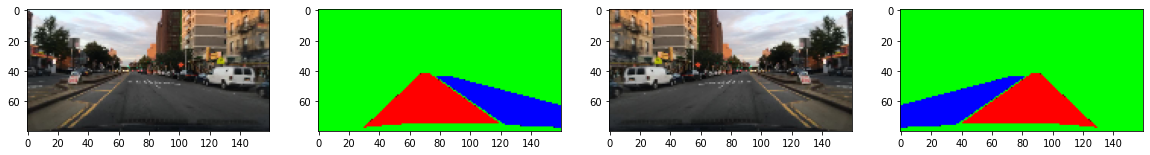

In [ ]:
# Visualize randdom images
f, (ax1,ax2,ax3,ax4) = plt.subplots(1,4, figsize=(20,10))
ax1.imshow(images[0])
ax2.imshow(labels[0])
ax3.imshow(flipped_images[0])
ax4.imshow(flipped_labels[0])

In [ ]:
# Dataset prep
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
images = np.array(images)
labels = np.array(labels)
images,labels = shuffle(images,labels)
x_train, x_val, y_train, y_val = train_test_split(images,labels,test_size=0.15)
n_train = len(x_train)
n_val = len(x_val)

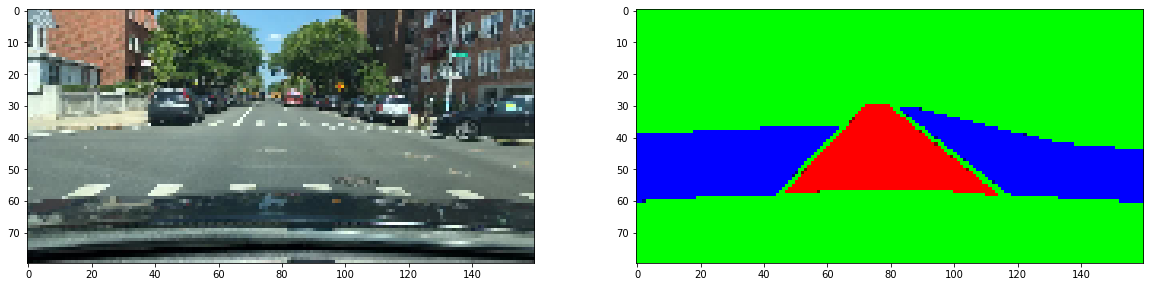

In [ ]:
# Display random images
import random as random
index = random.randint(0,len(labels))
f,(ax1,ax2) = plt.subplots(1,2, figsize=(20,10))
ax1.imshow(images[index].squeeze())
ax2.imshow(labels[index].squeeze())

In [ ]:
print(len(images))
print(len(labels))
print(images[0].shape)
print(labels[0].shape)

6000
6000
(80, 160, 3)
(80, 160, 3)


In [ ]:
from tensorflow.python import keras
from tensorflow.python.keras.models import Sequential, Model
from tensorflow.python.keras.layers import Activation, Dropout, Conv2D, MaxPooling2D, Reshape, Input, add
from tensorflow.python.keras.layers import UpSampling2D, Conv2DTranspose
from tensorflow.python.keras.layers.normalization import BatchNormalization
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras import regularizers

In [ ]:
def simple_encode_decoder():
  input_x = Input(shape=(80,160,3))
  x = BatchNormalization(input_shape=(80,160,3))(input_x)
  x = Conv2D(32,(3,3),padding='valid',strides=(1,1),activation='relu')(x)
  x1 = BatchNormalization()(x)
  x = MaxPooling2D((2,2),)(x1)
  x = UpSampling2D(interpolation='bilinear')(x)
  x = add([x1,x])
  x = Conv2DTranspose(32,(3,3),strides=(1,1), padding='valid', activation='relu')(x)
  x = Conv2D(3,(1,1),strides=(1,1), padding='valid',activation='softmax')(x)
  return Model(input_x,x)
  

model = simple_encode_decoder()
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 80, 160, 3)] 0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 80, 160, 3)   12          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 78, 158, 32)  896         batch_normalization[0][0]        
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 78, 158, 32)  128         conv2d[0][0]                     
_______________________________________________________________________________________

In [ ]:
batch_size = 16
epochs = 10
pool_size =(2,2)
learning_rate = 0.01
steps_per_epoch = len(x_train)/batch_size
input_shape = x_train.shape[1:]

In [ ]:
!sudo pip install keras --upgrade 


Requirement already up-to-date: keras in /usr/local/lib/python3.6/dist-packages (2.4.3)


In [ ]:
import keras

datagen = ImageDataGenerator(channel_shift_range=0.2)
datagen.fit(x_train)
optim = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optim, loss='categorical_crossentropy')
history = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),steps_per_epoch=steps_per_epoch, epochs=epochs, verbose =1, )

Epoch 1/10
319/318 [==============================] - 7s 23ms/step - loss: 0.3739
Epoch 2/10
319/318 [==============================] - 7s 23ms/step - loss: 0.3711
Epoch 3/10
319/318 [==============================] - 7s 23ms/step - loss: 0.3706
Epoch 4/10
319/318 [==============================] - 7s 23ms/step - loss: 0.3694
Epoch 5/10
319/318 [==============================] - 7s 23ms/step - loss: 0.3704
Epoch 6/10
319/318 [==============================] - 7s 23ms/step - loss: 0.3693
Epoch 7/10
319/318 [==============================] - 7s 23ms/step - loss: 0.3699
Epoch 8/10
319/318 [==============================] - 7s 23ms/step - loss: 0.3698
Epoch 9/10
319/318 [==============================] - 7s 23ms/step - loss: 0.3698
Epoch 10/10
319/318 [==============================] - 7s 23ms/step - loss: 0.3693


In [ ]:
model.save("model.h5")

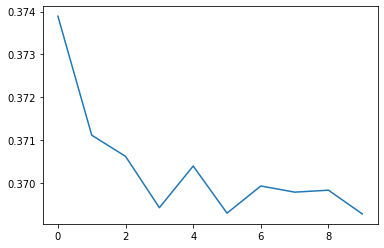

In [ ]:
plt.plot(history.history['loss'])

In [ ]:
def run(input_image):
  h, w , d = input_image.shape
  network_image = input_image.copy()
  network_image = cv2.resize(network_image,(160,80),interpolation=cv2.INTER_AREA)
  network_image = network_image[None,:,:,:]
  prediction = model.predict(network_image)[0]*255
  R,G,B = rgb_channel(prediction)
  blank = np.zeros_like(R).astype(np.uint8)
  lane_image = np.dstack((R,blank,B))
  lane_image = cv2.resize(lane_image,(w,h))
  plt.imshow(lane_image)
  result = cv2.addWeighted(input_image,1,lane_image.astype(np.uint8),1,0)
  return result

In [ ]:
def rgb_channel(img, thresholding=False,thres=230):
  image = np.copy(img)
  if thresholding:
    ret, image = cv2.threshold(image, thres, 255, cv2.THRESH_BINARY)
  R = image[:,:,0]
  G = image[:,:,1]
  B = image[:,:,2]
  return R,G,B

In [ ]:
result = mpimg.imread("./test.jpg")
res = run(x_val[0])


NameError: ignored